In [1]:
from AP_Merge import APMerge
from cytof_io import load_df
from sklearn.metrics import normalized_mutual_info_score as nmis
from sklearn.metrics import adjusted_rand_score as ars
import numpy as np

This notebook presents the Hierarchical Affinity Propagation with pre-clustering idea, applied to CyTOF data.
This algorithm consists of 4 steps:
    1. K-Means clustering of the data into small partitions.(150 used by default)
    1.1 Multiple initializations is used to avoid local minima. Nevertheless the clustering does not have to be perfect, or biologically relevant. The main point of this step is to divide the dataset into small spherical (hyper-spherical) partitions.
    2. The K-Means partitions are then used to construct a pairwise mahalanobis distance matrix of the clusters. This step is inspired by the flowMeans algorithm. The mahalanobis distance amplifies the distance of dispersed clusters and reduces the distance between dense clusters.
    Steps 1 and 2 are implemented in the APMerge.set_dm method.
    3. Preference values of the affinity propagation algorithm are determined from the distance matrix. The default values are the following percentiles of the flattened matrix: 50, 65, 95. The first value, the median, produces 9-10 clusters on this dataset, depending on random initializations. The second and third value result in 22-24 and 39-44 clusters, respectively.
    4. Affinity propagation is fit to the distance matrix for each preference value. This merges clusters that are close together based on their mahalanobis distance.

Pros and Cons of Hierarchical Affinity Propagation with pre-clustering:

Pros:
    1. Does not require number of clusters to be preset.
    2. Can find hierarchies in the data, which is often the purpose of Cytometry research.
    3. Can find rare cell populations. The plots below show some consistent small populations.
    4. Fast, since the majority of the computation is spent on KMeans which is the fastest clustering algorithm available. K-Means scales like- O(n*T*k) n-data points, T-steps, k-number of clusters. Or O(n*T*k*I) where I is number of initializations.

Cons:
    1. Dependent on random initializations. Results vary slightly between random initializations and this cannot be improved simply by increasing the number of initializations for K-Means. Sometimes there are multiple equally good clusterings.
    2. Higher number of clusters and initializations significantly slow down KMeans.
    3. The use of euclidean distance in K-Means might hinder the analysis of high dimensional data. This is possibly countered by the use of mahalanobis distance to merge partitions.

In [2]:
df, markers = load_df() # loads the Levine32 dimensions benchmark dataset.

Create three hierarchical affinity propagation models with the same parameters, but a different random seed each.

In [3]:
models = [APMerge(n_clusters=30, n_init=10, random_state=i, verbose=0, df=df, cols=markers) for i in range(3)]
[model.hierarchical_fit(percentiles=[50, 85, 95, 99]) for model in models]; ''

''

The hierarchies that find more clusters often do not converge. This is because the number of cluster changes frequently. In this case only one did not converge. This highlights the need for more than one initialization.

The next line plots a heatmap and a dendogram of the three clustering results at level 2.
The numbers on the leaves are the number of healthy cells in that cluster divided by the number of AML cells.
The numbers on the Y axis on the heatmap are the total number of cells in the clusters.

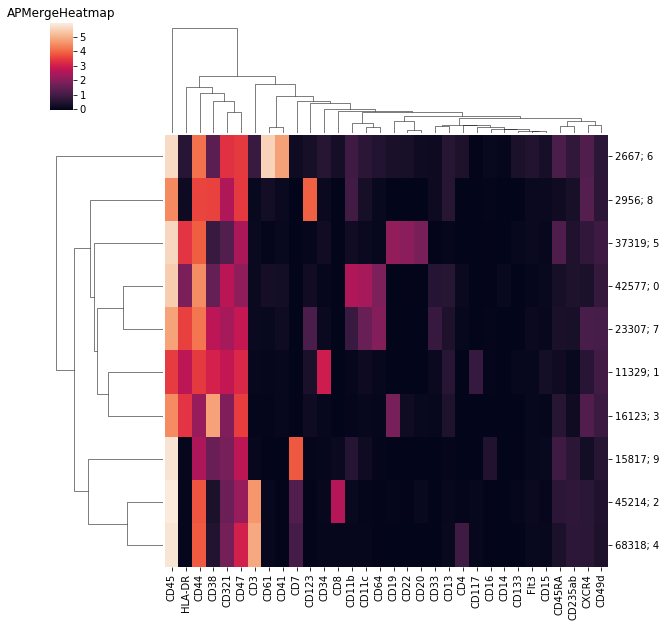

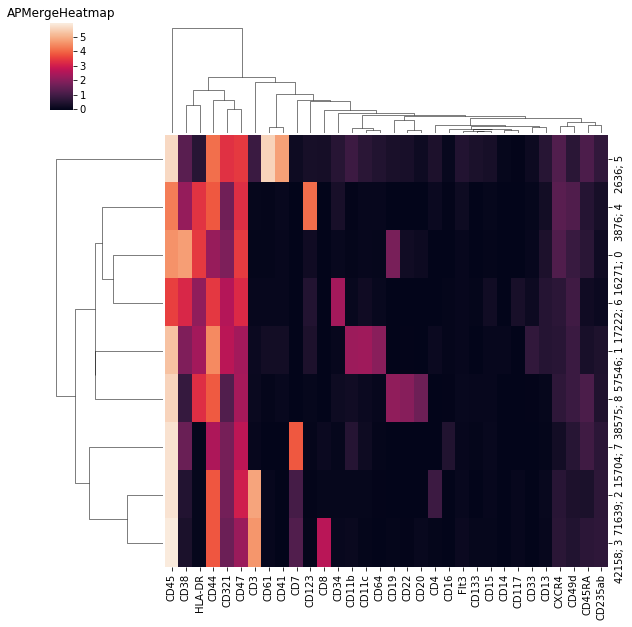

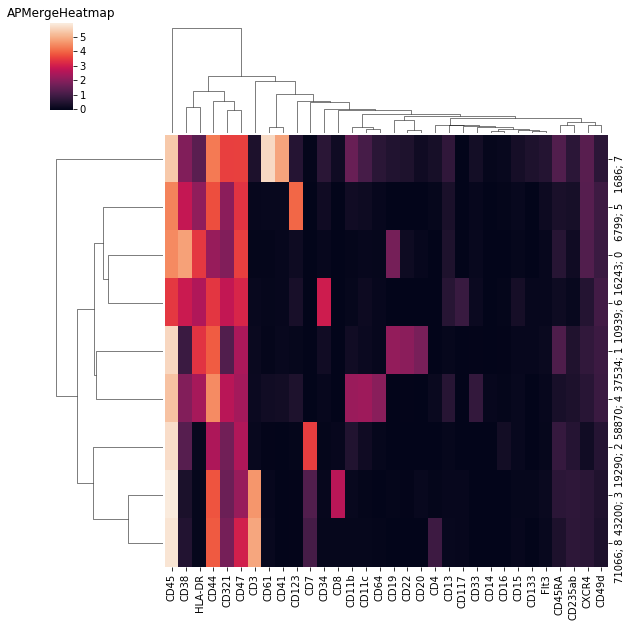

In [4]:
for model in models:
    model.plot_level(level=1, show=True, save=False) # this will raise a warning when the Phylo package is used.

As we can see from these plots, the cluster hierarchy is preserved between different random seeds, which could be improved by increasing the number of initializations. Some clusters are changed. The numbers in the different clusters change. This method is not computationally stable.

In [5]:
last_model = model.get_level(1)

The underlying heatmap for the plot of each level of the model is saved in model.get_level(level=level).heat_map

In [6]:
last_model.heat_map

,CD45RA,CD133,CD19,CD22,CD11b,CD4,CD8,CD34,Flt3,CD20,...,CD38,CD13,CD3,CD61,CD117,CD49d,HLA-DR,CD64,CD41,C
16243,0.592303,-0.006245,1.760950,0.211264,0.035619,-0.013580,-0.013258,0.088346,0.080235,0.096683,...,4.803765,0.469356,0.031604,0.043194,-0.016695,0.898064,3.455602,0.060433,0.087848,0
37534,1.206051,0.086291,2.178874,2.073349,0.247430,0.004968,0.004545,0.242489,0.130625,1.815941,...,0.892500,0.070636,0.138154,0.038141,-0.014341,0.936481,3.403734,0.092016,0.122011,1
19290,0.822265,-0.000347,-0.003785,-0.006465,0.506137,-0.004945,0.097600,0.049408,0.076192,-0.007936,...,1.312462,0.056396,0.108924,0.013417,-0.015449,0.584555,0.102956,0.066128,-0.007198,2
43200,0.668395,0.066353,0.041403,0.015309,0.122272,0.038258,2.688550,0.096472,0.144996,0.104656,...,0.406982,0.085428,4.650848,0.078027,0.082978,0.489548,0.063995,0.000578,-0.010810,3
58870,0.358023,-0.000526,-0.000679,0.019459,2.275230,0.144866,-0.001825,0.085896,0.091660,-0.011359,...,1.947380,0.589632,0.147035,0.259705,-0.013611,0.902585,2.431859,2.032342,0.272011,4
6799,0.397780,-0.006874,-0.008078,-0.008086,0.242899,0.071213,-0.009812,0.238277,0.182697,-0.010387,...,2.847775,0.393852,0.082153,0.112267,-0.012797,0.954820,2.146279,0.088993,0.117733,5
10939,0.211111,0.085198,-0.002276,-0.007797,0.057009,-0.009035,-0.002896,3.006262,0.086853,-0.010064,...,2.955853,0.610990,0.103259,0.062415,0.885789,1.017157,2.568383,0.086377,0.079345,6
1686,1.243161,0.457203,0.512809,0.469955,1.581356,0.339165,0.230885,0.654689,0.559267,0.220435,...,1.931903,0.735059,0.429667,5.655910,-0.003934,0.681428,1.356446,0.654551,4.856980,7
71066,0.426256,-0.002163,-0.004623,-0.007067,0.075149,0.943242,0.072157,0.064129,0.108557,-0.007478,...,0.536800,0.115082,4.890186,0.100276,0.098807,0.440832,0.058772,0.034327,-0.009686,8


The APMerge class can also do UMAP plots of the hierarchies. This is useful in determining clustering quality.
The clusterings with lower marker number results in better separation between the clusters in the UMAP plot.
This plot needs some improvement: a legend with cluster IDs that will make it easier to also look at the heatmap.

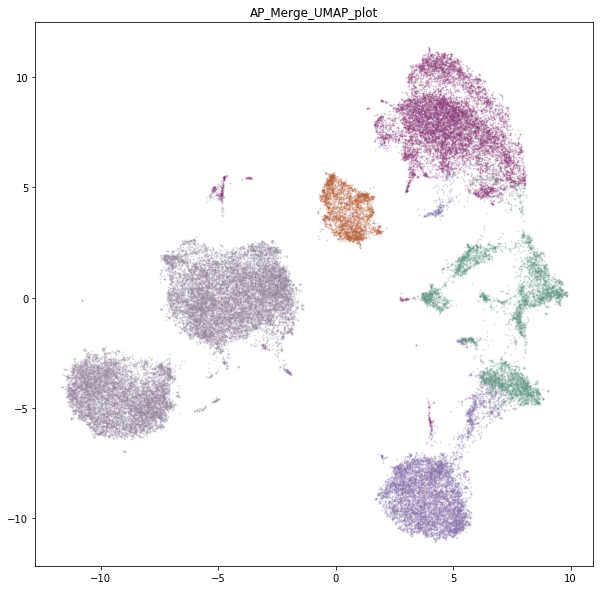

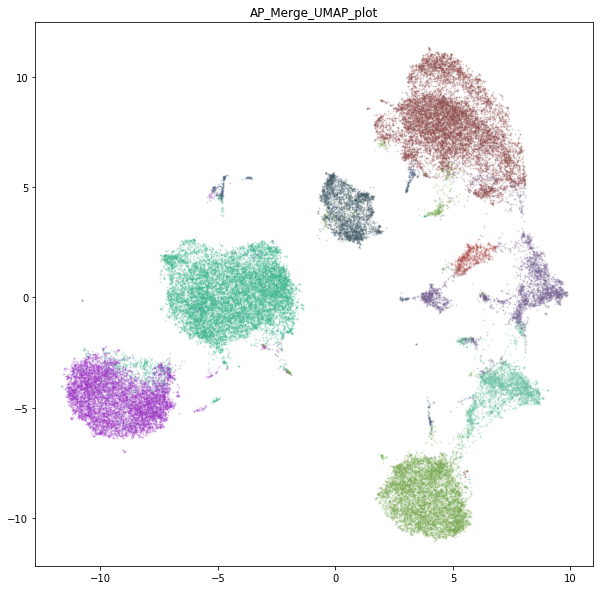

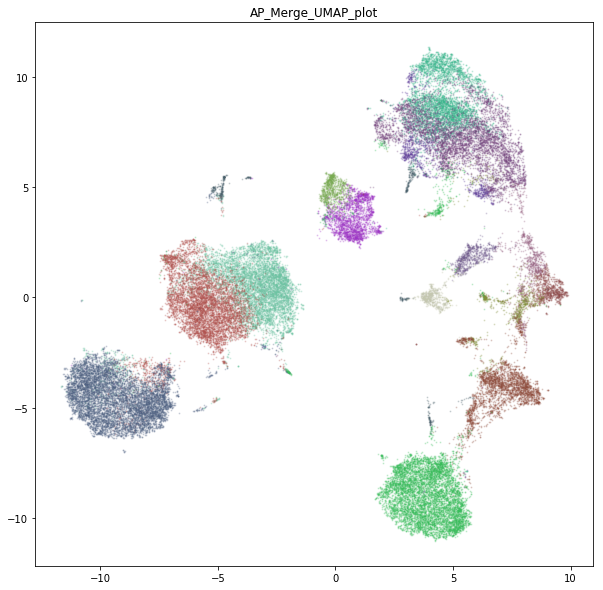

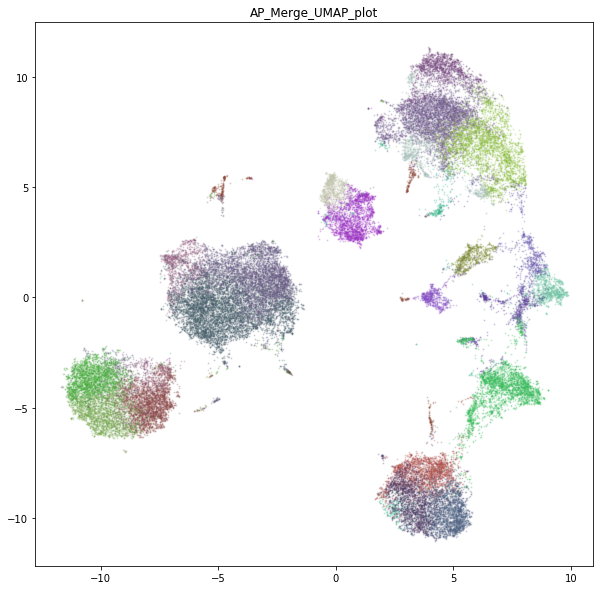

In [7]:
models[1].plot_maps(show=True, save=False, df=df, cols=markers)

In [8]:
[[_.models[k].n_clusters for k in sorted(_.models.keys())] for _ in models]

[[4, 10, 15, 25], [5, 9, 16, 23], [4, 9, 17, 27]]

Now that they have the same cluster size and have the labels computed, the clustering quality can be scored. This is good indication that the lower level hierarchies have found the "right" number of clusters.
This is a good statistic for this use case as it does not assume anything about the shape, size or density of the clusters. The silhouette statistic would as it measures distance between points and clusters (spherical assumption)

In [9]:
def score_level(model_list, level=0, metric=nmis):
    level_models = [_.models[sorted(_.models.keys())[level]] for _ in model_list]
    len_ = len(level_models)
    nmis_level = np.ones((len_, len_))
    for i in range(len_):
        for j in range(len_):

            nmis_level[i, j] = nmis(level_models[i].labels_, level_models[j].labels_)
    return nmis_level

In [10]:
for f_name, f in zip(['nmis', 'ars'], [nmis, ars]):
    for level in range(3):
        print('Level:', level, 'Metric: '+f_name)
        print(score_level(models, level=level, metric=f))

Level: 0 Metric: nmis
[[1.         0.79499506 0.84514807]
 [0.79499506 1.         0.8198933 ]
 [0.84514807 0.8198933  1.        ]]
Level: 1 Metric: nmis
[[1.         0.86060527 0.87248896]
 [0.86060527 1.         0.88488796]
 [0.87248896 0.88488796 1.        ]]
Level: 2 Metric: nmis
[[1.         0.80711637 0.82215457]
 [0.80711637 1.         0.78411596]
 [0.82215457 0.78411596 1.        ]]
Level: 0 Metric: ars
[[1.         0.79499506 0.84514807]
 [0.79499506 1.         0.8198933 ]
 [0.84514807 0.8198933  1.        ]]
Level: 1 Metric: ars
[[1.         0.86060527 0.87248896]
 [0.86060527 1.         0.88488796]
 [0.87248896 0.88488796 1.        ]]
Level: 2 Metric: ars
[[1.         0.80711637 0.82215457]
 [0.80711637 1.         0.78411596]
 [0.82215457 0.78411596 1.        ]]


The clustering results are not consistent in hierarchies with more clusters. The highest scores are 0.89 at level 0 (10 clusters).
This technique should mainly be used for exploratory data analysis, to see what is the structure of cells in the CyTOF dataset. The results could be improved by reducing the number of cells and marker after the first clustering, so as to remove cells that are definitely not in the populaitons of interest.